In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
np.random.seed(3)
pd.set_option('display.float_format', '{:,.8f}'.format)

In [2]:
# Define target predictors
target_predictors = ['AF', 'AGE_YRS', 'Allergic', 'Anemia', 'Asthma', 'CVD', 'Cancer', 'Dementia',
    'Hyperlipidemia', 'Kidney', 'Migraine', 'Thyroid', 'allergies',
    'anxiety', 'arthritis', 'copd', 'curr_ill', 'depression', 'diabetes',
    'disable', 'hypertension', 'obesity', 'othermeds', 'sex', 'MODERNA', 'PFIZER', 'JANSSEN']
print('Num of target predictors:', len(target_predictors))
target_prediction = 'NUMDAYS'
predictor_top_k = 8

smf_formula = target_prediction + ' ~ ' + ' + '.join(target_predictors)

Num of target predictors: 27


In [3]:
# Preprocess data
source_data = pd.read_csv('data21_2.csv', low_memory=False)
print('Column keys in vanilla data:', source_data.keys().values)

# Drop duplicate records of same VAERS_ID
source_data.drop_duplicates(subset='VAERS_ID', keep='first', inplace=True)

# Convert VAX_MANU to boolean properties
source_data['MODERNA'] = (source_data['manu'] == 0).astype('int')
source_data['PFIZER'] = (source_data['manu'] == 2).astype('int')
source_data['JANSSEN'] = (source_data['manu'] == 3).astype('int')

# Keep needed columns
source_data = source_data[target_predictors + [target_prediction]]
source_data.dropna(inplace=True)
source_data.reset_index(drop=True, inplace=True)

# Declare NUMDAYS as int
source_data['NUMDAYS'] = source_data['NUMDAYS'].astype('int')

print('Shape of processed source data:', source_data.shape)

Column keys in vanilla data: ['VAERS_ID' 'RECVDATE' 'STATE' 'AGE_YRS' 'CAGE_YR' 'CAGE_MO' 'RPT_DATE'
 'SYMPTOM_TEXT' 'DIED' 'DATEDIED' 'L_THREAT' 'ER_VISIT' 'HOSPITAL'
 'HOSPDAYS' 'X_STAY' 'RECOVD' 'NUMDAYS' 'LAB_DATA' 'V_ADMINBY' 'V_FUNDBY'
 'HISTORY' 'PRIOR_VAX' 'SPLTTYPE' 'FORM_VERS' 'TODAYS_DATE' 'BIRTH_DEFECT'
 'OFC_VISIT' 'ER_ED_VISIT' 'VAX_TYPE' 'VAX_LOT' 'VAX_DOSE_SERIES'
 'VAX_ROUTE' 'VAX_SITE' 'VAX_NAME' 'SYMPTOM1' 'SYMPTOMVERSION1' 'SYMPTOM2'
 'SYMPTOMVERSION2' 'SYMPTOM3' 'SYMPTOMVERSION3' 'SYMPTOM4'
 'SYMPTOMVERSION4' 'SYMPTOM5' 'SYMPTOMVERSION5' 'date_vax' 'date' 'dur'
 'Allergic' 'diabetes' 'hypertension' 'arthritis' 'Asthma' 'Migraine'
 'copd' 'anxiety' 'obesity' 'depression' 'Thyroid' 'Anemia' 'Dementia'
 'Cancer' 'Kidney' 'Hyperlipidemia' 'CVD' 'AF' 'othermeds' 'curr_ill'
 'sex' 'allergies' 'disable' 'manu']
Shape of processed source data: (242719, 28)


In [4]:
# Show distinct counts of each column (make sure that not too many columns have many distinct values)
print([source_data[predictor].nunique() for predictor in target_predictors])

[2, 98, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [5]:
# Scale the source data (for feature importance analysis)
# scaler = StandardScaler()
# source_data_scaled = scaler.fit_transform(source_data[target_predictors], source_data[target_prediction])
# source_data_scaled = pd.DataFrame(source_data_scaled, columns=target_predictors)
# source_data.update(source_data_scaled)

# Normalize age with min-max normalization
source_data['AGE_YRS'] = (source_data['AGE_YRS'] - source_data['AGE_YRS'].min()) / (source_data['AGE_YRS'].max() - source_data['AGE_YRS'].min())

In [6]:
# Shuffle data and slice it into training set and test set
source_data = source_data.sample(frac=1, random_state=1).reset_index(drop=True)

len_train = int(source_data.shape[0] * 0.8)
len_test = source_data.shape[0] - len_train

training_data = source_data.loc[:len_train]
test_data = source_data.loc[len_train:]
print('Shape of training set:', training_data.shape)
print('Shape of test set:', test_data.shape)

Shape of training set: (194176, 28)
Shape of test set: (48544, 28)


In [7]:
# And also slice data into two sets with larger/smaller 'NUMDAYS'
shorter_data = source_data[source_data['NUMDAYS'] <= 3].reset_index(drop=True)
longer_data = source_data[source_data['NUMDAYS'] > 3].reset_index(drop=True)
print('Shape of data with shorter onset:', shorter_data.shape)
print('Shape of data with longer onset:', longer_data.shape)

Shape of data with shorter onset: (189098, 28)
Shape of data with longer onset: (53621, 28)


# Util functions

In [8]:
def get_rmse(real_val, pred_val):
	return mean_squared_error(real_val, pred_val, squared=False)

def get_r_square(real_val, pred_val):
	return r2_score(real_val, pred_val)

def print_top_k_predictors(importances, label, ascending, sort_key=lambda x:x):
	series = importances if isinstance(importances, pd.Series) else pd.Series(importances, index=target_predictors)
	series.sort_values(key=sort_key, ascending=ascending, inplace=True)
	print(f'Top {predictor_top_k} predictors of {label}:')
	print(series[:predictor_top_k].to_string())

# Ordinary Least Squares (OLS)

In [9]:
model = smf.ols(smf_formula, data=training_data)
model_short = smf.ols(smf_formula, data=shorter_data)
model_long = smf.ols(smf_formula, data=longer_data)
ols = model.fit()
ols_short = model_short.fit()
ols_long = model_long.fit()

In [10]:
train_pred = ols.fittedvalues
test_pred = ols.predict(test_data)
print(f'Train RMSE   {get_rmse(training_data[target_prediction], train_pred):11.8f}')
print(f'Test  RMSE   {get_rmse(test_data[target_prediction], test_pred):11.8f}')
print()
print_top_k_predictors(ols_short.pvalues.drop(labels='Intercept'), 'OLS (shorter)', True)
print()
print_top_k_predictors(ols_long.pvalues.drop(labels='Intercept'), 'OLS (longer)', True)

Train RMSE    5.37476719
Test  RMSE    5.34606323

Top 8 predictors of OLS (shorter):
AGE_YRS        0.00000000
othermeds      0.00000000
disable        0.00000000
sex            0.00000000
hypertension   0.00000000
Asthma         0.00000000
allergies      0.00000000
depression     0.00001737

Top 8 predictors of OLS (longer):
AGE_YRS        0.00000000
sex            0.00000000
disable        0.00000000
allergies      0.00000000
othermeds      0.00000000
hypertension   0.00055170
diabetes       0.00055270
anxiety        0.01023978


# Regularized regression

## Lasso

In [11]:
lasso_params = { 'L1_wt': 1 }
lasso = model.fit_regularized(**lasso_params)
lasso_short = model_short.fit_regularized(refit=True, **lasso_params)
lasso_long = model_long.fit_regularized(refit=True, **lasso_params)

In [12]:
train_pred = lasso.fittedvalues
test_pred = lasso.predict(test_data)
print(f'Train RMSE   {get_rmse(training_data[target_prediction], train_pred):11.8f}')
print(f'Test  RMSE   {get_rmse(test_data[target_prediction], test_pred):11.8f}')
print()
print_top_k_predictors(np.multiply(lasso_short.params[1:], shorter_data[target_predictors].std(axis=0, ddof=0)), 'Lasso (shorter)', False, sort_key=abs)
print()
print_top_k_predictors(np.multiply(lasso_long.params[1:], longer_data[target_predictors].std(axis=0, ddof=0)), 'Lasso (longer)', False, sort_key=abs)

Train RMSE    5.37476680
Test  RMSE    5.34605841

Top 8 predictors of Lasso (shorter):
MODERNA        2,544,385,818.77748919
PFIZER         2,511,324,760.85695314
JANSSEN        1,455,360,771.40183496
othermeds                  0.09442050
AGE_YRS                    0.07850021
disable                    0.02692668
sex                       -0.02611567
hypertension               0.02130533

Top 8 predictors of Lasso (longer):
MODERNA     2,164,305,882,953.66723633
PFIZER      2,049,373,140,037.42504883
JANSSEN     1,035,907,112,054.50830078
AGE_YRS                     0.62097464
sex                        -0.47056371
allergies                  -0.35361709
othermeds                  -0.30170774
disable                     0.26998091


## Ridge

In [13]:
ridge_params = { 'L1_wt': 0 }
ridge = model.fit_regularized(**ridge_params)
ridge_short = model_short.fit_regularized(refit=True, **ridge_params)
ridge_long = model_long.fit_regularized(refit=True, **ridge_params)

In [14]:
train_pred = ridge.fittedvalues
test_pred = ridge.predict(test_data)
print(f'Train RMSE   {get_rmse(training_data[target_prediction], train_pred):11.8f}')
print(f'Test  RMSE   {get_rmse(test_data[target_prediction], test_pred):11.8f}')
print()
print_top_k_predictors(np.multiply(ridge_short.params[1:], shorter_data[target_predictors].std(axis=0, ddof=0)), 'Ridge (shorter)', False, sort_key=abs)
print()
print_top_k_predictors(np.multiply(ridge_long.params[1:], longer_data[target_predictors].std(axis=0, ddof=0)), 'Ridge (longer)', False, sort_key=abs)

Train RMSE    5.37476777
Test  RMSE    5.34606815

Top 8 predictors of Ridge (shorter):
MODERNA        2,544,385,818.77841282
PFIZER         2,511,324,760.85690069
JANSSEN        1,455,360,771.40250015
othermeds                  0.09442050
AGE_YRS                    0.07850021
disable                    0.02692668
sex                       -0.02611567
hypertension               0.02130533

Top 8 predictors of Ridge (longer):
MODERNA     2,164,305,882,953.63818359
PFIZER      2,049,373,140,037.39379883
JANSSEN     1,035,907,112,054.52087402
AGE_YRS                     0.62097464
sex                        -0.47056371
allergies                  -0.35361709
othermeds                  -0.30170774
disable                     0.26998091


## ElasticNet

*L1 ratio = 0.5*

In [15]:
elastic_params = { 'L1_wt': 0.5 }
elastic = model.fit_regularized(**elastic_params)
elastic_short = model_short.fit_regularized(refit=True, **elastic_params)
elastic_long = model_long.fit_regularized(refit=True, **elastic_params)

In [16]:
train_pred = elastic.fittedvalues
test_pred = elastic.predict(test_data)
print(f'Train RMSE   {get_rmse(training_data[target_prediction], train_pred):11.8f}')
print(f'Test  RMSE   {get_rmse(test_data[target_prediction], test_pred):11.8f}')
print()
print_top_k_predictors(np.multiply(elastic_short.params[1:], shorter_data[target_predictors].std(axis=0, ddof=0)), 'ElasticNet (shorter)', False, sort_key=abs)
print()
print_top_k_predictors(np.multiply(elastic_long.params[1:], longer_data[target_predictors].std(axis=0, ddof=0)), 'ElasticNet (longer)', False, sort_key=abs)

Train RMSE    5.37476680
Test  RMSE    5.34605841

Top 8 predictors of ElasticNet (shorter):
MODERNA        2,544,385,818.77748919
PFIZER         2,511,324,760.85695314
JANSSEN        1,455,360,771.40183496
othermeds                  0.09442050
AGE_YRS                    0.07850021
disable                    0.02692668
sex                       -0.02611567
hypertension               0.02130533

Top 8 predictors of ElasticNet (longer):
MODERNA     2,164,305,882,953.66723633
PFIZER      2,049,373,140,037.42504883
JANSSEN     1,035,907,112,054.50830078
AGE_YRS                     0.62097464
sex                        -0.47056371
allergies                  -0.35361709
othermeds                  -0.30170774
disable                     0.26998091


# Random Forest

In [17]:
regressor_rf = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=1)
regressor_rf.fit(training_data[target_predictors], training_data[target_prediction])

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=1)

In [18]:
train_pred = regressor_rf.predict(training_data[target_predictors])
test_pred = regressor_rf.predict(test_data[target_predictors])
print(f'Train RMSE   {get_rmse(training_data[target_prediction], train_pred):11.8f}')
print(f'Test  RMSE   {get_rmse(test_data[target_prediction], test_pred):11.8f}')

Train RMSE    4.85614301
Test  RMSE    5.55824576


In [19]:
# Get numerical feature importances
importances = list(regressor_rf.feature_importances_)
print_top_k_predictors(importances, 'RandomForest', False)

Top 8 predictors of RandomForest:
AGE_YRS        0.36330046
curr_ill       0.05775200
allergies      0.03771437
Thyroid        0.03756740
hypertension   0.03301878
arthritis      0.03299307
MODERNA        0.03236857
othermeds      0.03203971


# Simple Multi-Layer Perceptrons

In [20]:
regressor_nn = MLPRegressor(hidden_layer_sizes=(5, 5), activation='relu', random_state=1)
regressor_nn.fit(training_data[target_predictors], training_data[target_prediction])

MLPRegressor(hidden_layer_sizes=(5, 5), random_state=1)

In [21]:
train_pred = regressor_nn.predict(training_data[target_predictors])
test_pred = regressor_nn.predict(test_data[target_predictors])
print(f'Train RMSE   {get_rmse(training_data[target_prediction], train_pred):11.8f}')
print(f'Test  RMSE   {get_rmse(test_data[target_prediction], test_pred):11.8f}')

Train RMSE    5.35583174
Test  RMSE    5.34015807


In [22]:
coefs = regressor_nn.coefs_[0]
importances = np.sum(np.abs(coefs), axis=1)
print_top_k_predictors(importances, 'MLP', False)

Top 8 predictors of MLP:
Hyperlipidemia   6.05031069
Allergic         4.43689607
AGE_YRS          4.31737618
JANSSEN          3.90474428
Dementia         3.69526978
Migraine         3.16767773
disable          2.91624165
Kidney           2.44109858


# Miscellaneous

In [23]:
# Check std of NUMDAYS with different kinds of vaccine
print(source_data.loc[source_data['PFIZER'] == 1, 'NUMDAYS'].std())
print(source_data.loc[source_data['MODERNA'] == 1, 'NUMDAYS'].std())
print(source_data.loc[source_data['JANSSEN'] == 1, 'NUMDAYS'].std())

5.371749212054234
5.561183592063984
4.677709768981316


<AxesSubplot:>

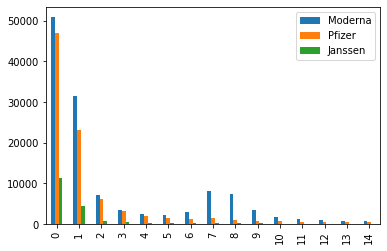

In [24]:
pd.concat([
	source_data.query('MODERNA == 1 and NUMDAYS <= 14')['NUMDAYS'].value_counts().sort_index(),
	source_data.query('PFIZER == 1 and NUMDAYS <= 14')['NUMDAYS'].value_counts().sort_index(),
	source_data.query('JANSSEN == 1 and NUMDAYS <= 14')['NUMDAYS'].value_counts().sort_index(),
], axis=1, keys=['Moderna', 'Pfizer', 'Janssen']).plot.bar()